In [10]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score
import pickle as pk
import lightgbm as lg
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix
from fonction import kpi, plot_auc, Mise_enforme, mat_conf2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score,RepeatedStratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
# from lazypredict.Supervised import LazyClassifier
import lightgbm as lgb
scaler = StandardScaler()
imputer = KNNImputer(n_neighbors=100)
import shap



ModuleNotFoundError: No module named 'sklearn'

In [2]:
spaceship_path = r'.\train.csv'
spaceship_df = pd.read_csv(filepath_or_buffer = spaceship_path, delimiter = ',')

In [3]:
def get_total_expenses(df):
    df['TotalExpenditures'] = df['RoomService']+df['FoodCourt']+df['ShoppingMall']+df['Spa']+df['VRDeck']
    return df


In [4]:
def get_age_decade(df):
    df['Age'] = df['Age'].replace(0, df['Age'].mean())
    spaceship_df['Age'] = imputer.fit_transform(spaceship_df[['Age']])
    df['AgeSquared'] = df['Age']**2 
    df['AgeByDecade'] = pd.cut(x=df['Age'], bins=[0, 20, 29, 49, 79], labels=['Teens', '20s', '30s-40s', 'Elderly'])               
    return df

In [5]:
def get_percent_cols(df,amenatiesSpendingCols):
    for col in amenatiesSpendingCols:
        df[col + 'Percent'] = df[col].div(df['TotalExpenditures']).replace(np.inf, 0).replace(np.nan, 0)
        df[col + 'Bool'] = np.where(df[col] > 0, 1, 0)
    return df


In [6]:
def get_cabin_col(df):
    df['Cabin_deck'], df['Cabin_num'], df['Cabin_side'] = df['Cabin'].str[0], df['Cabin'].str.split('/', expand=True)[1], df['Cabin'].str[-1]
    return df

In [7]:
def get_group_id(df):
    df['group_id'] = df['PassengerId'].str.split('_', expand=True)[0]
    return df

In [8]:
def get_acc_persons(df):
    df['NumOfAccPersons'] = df['group_id'].map(df['group_id'].value_counts()) 
    return df


In [9]:
def is_in_group(df):    
    df['isInGroup'] = np.where(df['NumOfAccPersons'] > 1, 1, 0)
    return df



In [10]:
def get_family_name(df):
    df['familyName'] = df[~pd.isnull(df['Name'])]['Name'].apply(lambda x: x.split(' ')[-1])
    return df



In [11]:
def get_pass_in_cab(df):
 
    df['NbPassengersInCabin'] = df.groupby('Cabin')['Cabin'].transform('count')
    return df

In [12]:
def get_fam_mbr_in_cabin(df):
    df['NbFamMbmInCabin'] = df.groupby(['Cabin', 'familyName'])['familyName'].transform('count')
    return df

In [13]:
def get_fam_mbr_in_grp(df):

    df['NbFamInSameGroup'] = df.groupby(['group_id', 'familyName'])['familyName'].transform('count')
    return df


In [14]:
def get_fam_exp(df):

    df['TotalExpensesofFamily'] = df.groupby('familyName')['TotalExpenditures'].transform('sum')

    return df

In [15]:
def journey_features(df):
    '''
    This function build a set of features from based on passenger's journey:
        From HomePlanet to Destination
    '''
    assert set(['HomePlanet', 'Destination']).issubset(set(df.columns))
    # Journey tupple creation
    df['Journey'] = df[['HomePlanet', 'Destination']].apply(lambda x: (x[0], x[1]), axis=1)
    # Dummification of Journey feature
    for v in df.Journey.unique():
        if v[0]!='' and v[1]!='':
            df.loc[df['Journey'] == v, 'Journey_from_{}_to_{}'.format(v[0], v[1])] = 1
            df['Journey_from_{}_to_{}'.format(v[0], v[1])].fillna(0, inplace=True)   
    if 'Journey_from_nan_to_nan' in df.columns:
        df = df.drop('Journey_from_nan_to_nan', axis=1)

    return df

In [16]:
def get_start_distance_to_sun(df):
    # In Light Minute
    dict={ 'Europa': 39.5 ,'Earth':8.3,'Mars': 13.8 }
    df['Start_Dist_Sun'] = df['HomePlanet'].map(dict)
    return df

In [17]:
def get_dest_distance_to_sun(df):
    # In Light Minutes
    dict={ 'TRAPPIST-1e': 20502400 ,'PSO J318.5-22':42048000 ,'55 Cancri e': 21478400  }
    df['Dest_Dist_Sun'] = df['Destination'].map(dict)
    return df

In [18]:
def get_dest_distance_to_earth(df):
    # In Light Year
    dict={ 'TRAPPIST-1e': 39 ,'PSO J318.5-22':80 ,'55 Cancri e': 40  }
    df['Dest_Dist_Earth'] = df['Destination'].map(dict)
    return df

In [19]:
def get_dest_habitability(df):
    # We have give the Habitability range scale over 10
    dict={ 'TRAPPIST-1e': 8  ,'PSO J318.5-22': 1 ,'55 Cancri e': 3  }
    df['Dest_Habitability'] = df['Destination'].map(dict)
    return df

In [20]:
def get_homeplnt_habitability(df):
    # We have give the Habitability range scale over 10
    dict={ 'Europa': 7 ,'Earth':10,'Mars': 4 }
    df['Home_Habitability'] = df['HomePlanet'].map(dict)
    return df

In [21]:

def get_distance_between_planets(df):
    # Light Years
    terrapist_dict = { 'Europa ': 40  ,'Earth': 39 ,'Mars': 39.5  }
    pso_dict = { 'Europa ': 80   ,'Earth': 80  ,'Mars': 80.5  }
    cann_dict = { 'Europa ': 41   ,'Earth': 41  ,'Mars': 41.5  }
    def calculate_distance(row):
        homeplanet = row['HomePlanet']
        destination = row['Destination']
        if destination == 'TRAPPIST-1e':
            distance = terrapist_dict.get(homeplanet, 0)
        elif homeplanet == 'PSO J318.5-22':
            distance = pso_dict.get(homeplanet, 0)
        elif homeplanet == '55 Cancri e':
            distance = cann_dict.get(homeplanet, 0)
        else:
            distance = 0
        return distance

    # Apply the function to create the new column
    df['distance'] = df.apply(calculate_distance, axis=1)
    return df

In [22]:
def get_planets_temp(df):
    # Temperature in degree celcus
    dest_dict={ 'TRAPPIST-1e': -27.1 ,'PSO J318.5-22':600 ,'55 Cancri e': 1000}
    home_dict={ 'Europa':  -160 ,'Earth':15,'Mars': -63 }
    df['Start_Plnt_Tmp']=df['HomePlanet'].map(home_dict)
    df['Dest_Plnt_Tmp']=df['Destination'].map(dest_dict)
    df['Diff_Tmp']=df['Start_Plnt_Tmp']-df['Dest_Plnt_Tmp']
    return df

In [23]:
def get_dest_freq(df):
    df['Dest_frq'] = df.groupby('Destination')['Destination'].transform('count')
    return df

In [24]:
def get_homeplnt_freq(df):
    df['Homeplnt_frq'] = df.groupby('HomePlanet')['HomePlanet'].transform('count')
    return df
    

In [25]:
def get_dest_gravity(df):
    # in m/s^2
    dest_dict={'TRAPPIST-1e': 9.4 ,'PSO J318.5-22': 25.2 ,'55 Cancri e': 25.9 }
    df['Dest_Gravity'] = df['Destination'].map(dest_dict)
    return df

In [26]:
def get_homplnt_gravity(df):
    # in m/s^2
    home_dict={ 'Europa': 1.315  ,'Earth':9.81 ,'Mars': 3.71 }
    df['Hmplnt_Gravity'] = df['HomePlanet'].map(home_dict)
    return df

In [27]:
def get_total_expensises_cabin_num(df):
    df['TotalExpensesofCabinNum'] = df.groupby('Cabin_num')['TotalExpenditures'].transform('sum')
    return df

In [28]:
def get_total_expensises_age_decade(df):
    df['TotalExpensesperAgeDecade'] = df.groupby('Age')['TotalExpenditures'].transform('sum')
    return df

In [29]:
def get_expences_cabin_num(df):
    ExpendituresCols = ['RoomService', 'FoodCourt','ShoppingMall', 'Spa', 'VRDeck']
    for col in ExpendituresCols:
        df[col+'ofCabinNum'] = df.groupby('Cabin_num')[col].transform('sum')
    return df

In [30]:
def ExtractFeatures(df):
    '''
        Extract new feature from already existing features in the DataFrame
        The new extracted features are the following: - TotalExpenditures
                                                      - AgeByDecade
                                                      - RoomServicePercent
                                                      - FoodCourtPercent
                                                      - ShoppingMallPercent
                                                      - SpaPercent
                                                      - VRDeckPercent
                                                      - RoomServiceBool 
                                                      - FoodCourtBool
                                                      - ShoppingMallBool
                                                      - SpaBool
                                                      - VRDeckBool
                                                      - Cabin_deck
                                                      - Cabin_num
                                                      - Cabin_side
                                                      - group_id
                                                      - NumOfAccPersons
                                                      - isInGroup
                                                      - familyName
                                                      - NumOfFamilyMembers
    '''
    
    try:
        expectedFeatures = ['group_id','familyName','PassengerId', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Age', 'Cabin', 'Name']
        amenatiesSpendingCols = ['RoomService', 'FoodCourt', 'VRDeck', 'ShoppingMall', 'Spa']
        assert all(elem in df.columns for elem in expectedFeatures) 
        
        
        df = get_total_expenses(df)
        # Binning Age by 4 categories : Teens (less thanh 20), 20s, 30s-40s and 50+
        df = get_age_decade(df)

        # Creating columns of Spending Percentages of Total Spendings
        # Transforming Amenaties Expenses from Numerical to Categorical Binary Variables (1, 0) --> 1 if spending else 0
        df = get_percent_cols(df, amenatiesSpendingCols)
        # Splitting Cabin into 3 features : Cabin_deck, Cabin_num and Cabin_side
        
        df = get_cabin_col(df)
        # Splitting PassengerId into 2 Features : isInGroup (whether the passenger is alone or not) and NumOfAccPersons(Number of people with the passenger)
        
        # df = get_group_id(df)

        df = get_acc_persons(df)

        df = is_in_group(df)
        # Getting the Family name and 
        # df = get_family_name(df)
        
        # Nb Passengers In Same Cabin
        df = get_pass_in_cab(df)

        # Nb of family members in same group
        # df = get_fam_mbr_in_cabin(df)

        # Nb of family members in same group
        df = get_fam_mbr_in_grp(df)
  
        # Family Expenses
        df = get_fam_exp(df)

        # Journey Features
        df = journey_features(df)

        # Distance From Homeplanet  to the SUN
        df = get_start_distance_to_sun(df)

        # Distance From Destination Planet to the SUN
        df = get_dest_distance_to_sun(df)

        # Distance From Destination Planet to Earth
        df = get_dest_distance_to_earth(df)

        # Planets Temperature
        df = get_planets_temp(df)

        # Planets Destination Habitability
        df = get_dest_habitability(df)

        # Home Planets Habitability
        df = get_homeplnt_habitability(df)

        # Destination Frequency
        df = get_dest_freq(df)

        # HomePlanet Frequency
        df = get_homeplnt_freq(df)

        # Distance between Home and Destination Planet
        df = get_distance_between_planets(df)

        # Destinavtion Gravity Value
        df = get_dest_gravity(df)

        # Homeplanet Gravity
        df = get_homplnt_gravity(df)

        # Total Expenses Group By Cabin Number
        df = get_total_expensises_cabin_num(df)
        
        df = get_total_expensises_age_decade(df)

        df =  get_expences_cabin_num(df)
        return df 
    except AssertionError:
        return df 

In [31]:
def encode_fam_name(df):
    # # calculate the frequency of each category
    family_freq = df['familyName'].value_counts(normalize=True)
    # # encode the categories with their frequency
    df['familyName'] = df['familyName'].map(family_freq)
    
    return df

In [32]:
def dumify_cat_col(df, categoricalCols):
    for col in categoricalCols:
        df = pd.get_dummies(df, columns=[col], prefix=col)
    return df

In [33]:
def scale_data(X_train,X_test):
   
    X_train_scaled = scaler.fit_transform(X_train)
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

    X_test_scaled = scaler.fit_transform(X_test)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)


    return X_train_scaled_df,X_test_scaled_df

In [34]:
def get_scaled_dataframe(df):
    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [35]:
def export_to_excel(df):
    df.to_csv('data.csv')

In [36]:
def clean_spending_col(df,SpendingCols):
    df.replace({False: 0, True:1}, inplace=True)
    # Fill Missing values of CryoSleep 
    #if there at least one value of Expenditures Cols not equal 0 else 1
    for index, row in df[df['CryoSleep'].isnull()].iterrows():
        if row['RoomService'] !=0 or row['FoodCourt'] !=0 or row['ShoppingMall']!=0 or row['Spa']!=0 or  row['VRDeck']!=0:
            row['CryoSleep'] = 0
        else:
            1
    for col in SpendingCols:
        df.loc[df['CryoSleep'] == True, col] = df.loc[df['CryoSleep'] == True, col].fillna(0)
    df[SpendingCols] = imputer.fit_transform(df[SpendingCols])

    return df


In [37]:
def clean_age_col(df):
    # Replace Data with Age 0 by the mean of Age column Because its not logique People with Age 0 to Go to Moon 
    df['Age'] = df['Age'].replace(0, df['Age'].mean())
    # Fill Empty Values of Age
    df['Age'] = imputer.fit_transform(df[['Age']])
    return df

In [38]:
def clean_fam_name(df):
    df = get_group_id(df)
    df['familyName'] = df[~pd.isnull(df['Name'])]['Name'].apply(lambda x: x.split(' ')[-1])
    # Group the data by Group ID and fill the missing values with the family name of the same group
    df['familyName'] = df.groupby('group_id')['familyName'].fillna(method='ffill')
    return df


In [39]:
def clean_homeplanet(df):
    df['HomePlanet'].fillna(df.groupby('familyName')['HomePlanet'].ffill(), inplace=True)
    return df

In [40]:
def clean_VIP(df):
    # Fill missing values in VIP column with False when Cryosleep is True
    df.loc[df['CryoSleep'] == True, 'VIP'] = df['VIP'].fillna(False)
    # Fill missing values in VIP column with False when Cryosleep is False and Spending Columns are null
    df.loc[(df["CryoSleep"] == False) & (df["RoomService"] == 0) & (df["FoodCourt"] == 0) & (df["ShoppingMall"] == 0) & (df["Spa"] == 0) & (df["VRDeck"] == 0),'VIP']=df['VIP'].fillna(False)
    return df

In [41]:
def clean_deck_num(df):
    null_counts = spaceship_df.isnull().sum()
    null_counts_df = pd.DataFrame({'Column Name': null_counts.index, 'Null Count': null_counts.values})
    display(null_counts_df)
    df['Cabin'].fillna(df.groupby('group_id')['Cabin'].ffill(), inplace=True)
    null_counts = spaceship_df.isnull().sum()
    null_counts_df = pd.DataFrame({'Column Name': null_counts.index, 'Null Count': null_counts.values})
    display(null_counts_df)
    return df


In [42]:
def clean_cabin_num(df):

    df = get_cabin_col(df)
    # Group data by groupid, destination, homeplanet, and familyname, and forward fill the empty values in the Cabin_deck column
    df['Cabin_deck'].fillna(df.groupby(['group_id', 'familyName','HomePlanet','Destination'])['Cabin_deck'].ffill(), inplace=True)
    return df

In [43]:
def CleanData(df):
    # Fill Empty Value of CryoSleep
    df.replace({False: 0, True:1}, inplace=True)
    # Replace null values of Amenaty Expenses where CryoSleep = True with 0
    SpendingCols = ['RoomService', 'FoodCourt', 'VRDeck', 'ShoppingMall', 'Spa']
    # clean spending col
    df = clean_spending_col(df,SpendingCols)
    # clean Age col
    df = clean_age_col(df)
    # clean family name
    df = clean_fam_name(df)
    # df = clean_cabin_num(df)
    df = clean_homeplanet(df)
    df = clean_cabin_num(df)
    df = clean_VIP(df)
    # df = clean_deck_num(df)
    # df.to_csv('clean_test.csv',index = False)
    return df

In [44]:
# Replacing NaN values where CryoSleep = True with 0.0
def PrepareData(df, columnsToDrop,data_type, test_size=0.2, random_state=42):
    '''
       - Replace Null Values (using KNNImputer)
       - Dummify Categorical Variables
       - Drop Unused Columns
       - Split Data Between Train and Test
       - Scale Numerical Variables
       
           Input:   df --> Pandas DataFrame
           Output : X  --> numpy Matrix containing independent variables
                    y  --> numpy array containing the dependent variable
    '''
   
    
    # Encode Family Name column
    df = encode_fam_name(df)
    # Dummyfying Categorical columns 
    categoricalCols = ['HomePlanet', 'Destination', 'Cabin_deck', 'Cabin_side','AgeByDecade']
    # categoricalCols = [ 'Cabin_deck', 'Cabin_side','AgeByDecade']

    df = dumify_cat_col(df,categoricalCols)
    
    df.replace({False: 0, True:1}, inplace=True)
    # Dropping Unused Columns
    df.drop(columns=columnsToDrop, inplace=True)
    
    #Imputing Rest of Missing Variables 
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    if data_type == 'train':
        X = df.drop(columns=['Transported'])   
        y = df['Transported']

        # Get Scaled Train and Test Data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

        X_train_scaled,X_test_scaled= scale_data(X_train,X_test)
        return X_train_scaled, X_test_scaled, y_train, y_test
    
    elif data_type == 'test':    
        return get_scaled_dataframe(df)
   

In [45]:
# def logistic_regression_model(X_train, X_test, y_train, y_test, C=1.0, max_iter=5000, random_state=42):
#     cv5 = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
#     # Train the Model
#     params = {'C': [0.001, 0.01,0.03,0.04, 0.1, 1, 10, 100],
#               }
 
#     clf = LogisticRegression(C=0.04, random_state=random_state, max_iter=max_iter,solver='sag',penalty='l2')

#     clf.fit(X_train, y_train)

#     # cross validation
#     score_cv = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10)

#     print("Logistic Regression cross validate train : accuracy {} +/- {}".format(np.round(score_cv.mean(),2),
#                                                   np.round(score_cv.std(),2)))

#     score_cv = cross_val_score(estimator=clf,X=X_test,y=y_test,cv=10)
    
#     print("Logistic Regression cross validate Test : accuracy {} +/- {}".format(np.round(score_cv.mean(),2),
#                                                   np.round(score_cv.std(),2)))
#     print('Accuracy on training set: ', clf.score(X_train, y_train))
#     print('Accuracy on test set: ', clf.score(X_test, y_test))
#     print('Logistic Regression Accuracy: ', clf.score(X_test, y_test))
#     # Plot Confusion Matrix
#     figs, axs = plt.subplots(figsize=(14, 6), nrows=1, ncols=2)
#     figs.tight_layout(pad=10.0)
#     plot_confusion_matrix(clf, X_train, y_train, ax=axs[0])
#     axs[0].set_title('Train Data')
#     plot_confusion_matrix(clf, X_test, y_test, ax=axs[1])
#     axs[1].set_title('Test Data')
    
#     return clf

In [46]:
ExpendituresCols = ['RoomService', 'FoodCourt','ShoppingMall', 'Spa', 'VRDeck']
ExpendituresAgesCols =['AgeByDecade_Teens', 'AgeByDecade_20s','AgeByDecade_30s-40s', 'AgeByDecade_Elderly']
ExpendituresPercentCols = ['RoomServicePercent', 'FoodCourtPercent', 'ShoppingMallPercent', 'SpaPercent', 'VRDeckPercent']
ExpendituresBoolCols =  ['RoomServiceBool', 'FoodCourtBool', 'ShoppingMallBool', 'SpaBool', 'VRDeckBool']
ExpendituesTemperatureCols = ['Dest_Habitability', 'Home_Habitability']
ExpendituesDistanceCols = ['Start_Dist_Sun', 'Dest_Dist_Sun','Dest_Dist_Earth']
ExpendituesFrequecnyCols = ['Dest_frq', 'Homeplnt_frq'] 
ExpendituesGravityCols = ['Dest_Gravity', 'Hmplnt_Gravity'] 
ExpendituesHabitabilityCols = ['Dest_Habitability', 'Home_Habitability'] 
ExpendituesTemperatureCols = ['Start_Plnt_Tmp', 'Dest_Plnt_Tmp'] 

spaceship_df = CleanData(spaceship_df)
spaceshipExtraFeatures_df = ExtractFeatures(spaceship_df)
# clfs = {}

lgbm Accuracy: 0.7987349051178838


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


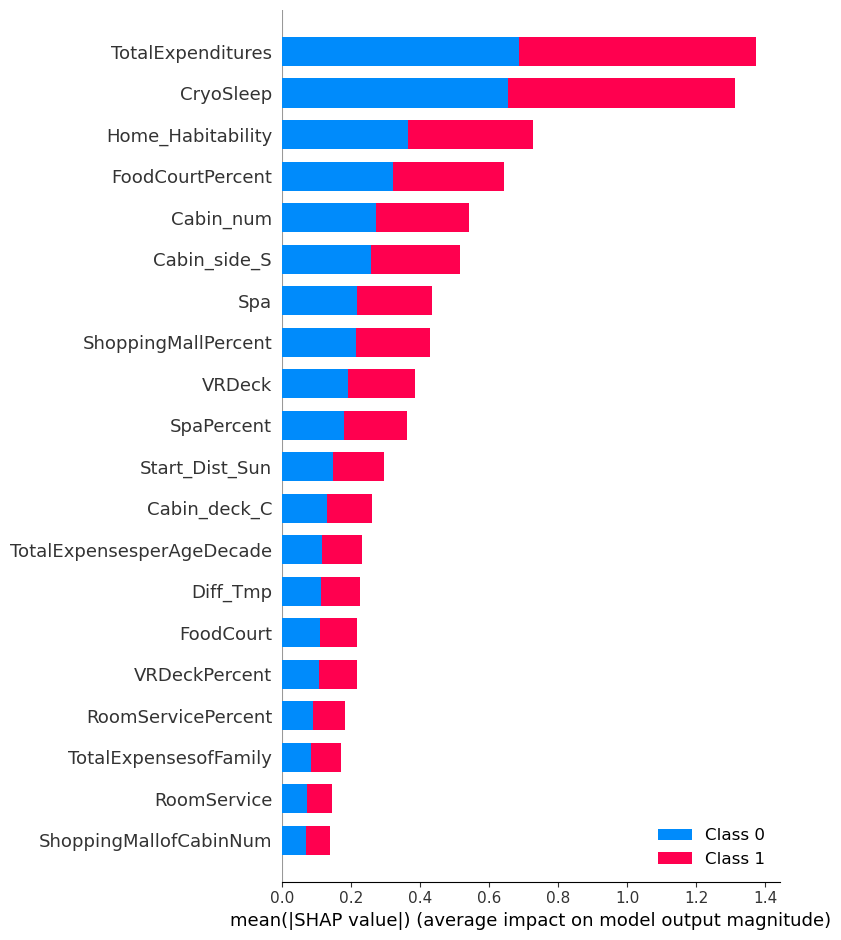

In [47]:
columnsToDrop = ['PassengerId','Cabin', 'group_id','Name', 'familyName','Journey',*ExpendituesTemperatureCols]
X_train, X_test, y_train, y_test = PrepareData(spaceshipExtraFeatures_df,columnsToDrop,'train')
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("lgbm Accuracy:", accuracy)
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar')

In [48]:
test_path = r'.\test.csv'
test_df = pd.read_csv(filepath_or_buffer = test_path, delimiter = ',')
test_df = CleanData(test_df)
test_dfExtraFeatures_df = ExtractFeatures(test_df)
X_test= PrepareData(test_dfExtraFeatures_df, columnsToDrop,'test')
missing_columns = set(X_train.columns) - set(X_test.columns)
y_pred =lgbm.predict(X_test)
# y_pred =clf_V1.predict(X_test)
data = {'PassengerId': test_dfExtraFeatures_df['PassengerId'],
        'Transported': y_pred
       }
df2 = pd.DataFrame(data)
df2.replace({0: False, 1:True}, inplace=True)
df2.to_csv('clean_cabintessv1.csv',index = False)

In [ ]:
# columnsToDrop = ['PassengerId','Cabin', 'group_id','Name', 'familyName','Journey',*ExpendituesTemperatureCols]
# X_train, X_test, y_train, y_test = PrepareData(spaceshipExtraFeatures_df,columnsToDrop,'train')
# lgbm = lgb.LGBMClassifier()
# lgbm.fit(X_train, y_train)
# y_pred = lgbm.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("lgbm Accuracy Without Temperature Cols:", accuracy)

In [ ]:
# columnsToDrop = ['PassengerId','Cabin', 'group_id','Name', 'familyName','Journey',*ExpendituesDistanceCols]
# X_train, X_test, y_train, y_test = PrepareData(spaceshipExtraFeatures_df,columnsToDrop,'train')
# lgbm = lgb.LGBMClassifier()
# lgbm.fit(X_train, y_train)
# y_pred = lgbm.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("lgbm Accuracy Without Distance Cols:", accuracy)

In [ ]:
# columnsToDrop = ['PassengerId','Cabin', 'group_id','Name', 'familyName','Journey',*ExpendituesFrequecnyCols]
# X_train, X_test, y_train, y_test = PrepareData(spaceshipExtraFeatures_df,columnsToDrop,'train')
# lgbm = lgb.LGBMClassifier()
# lgbm.fit(X_train, y_train)
# y_pred = lgbm.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("lgbm Accuracy Without Planets Frequency Cols:", accuracy)

In [ ]:
# columnsToDrop = ['PassengerId','Cabin', 'group_id','Name', 'familyName','Journey',*ExpendituesGravityCols]
# X_train, X_test, y_train, y_test = PrepareData(spaceshipExtraFeatures_df,columnsToDrop,'train')
# lgbm = lgb.LGBMClassifier()
# lgbm.fit(X_train, y_train)
# y_pred = lgbm.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("lgbm Accuracy Without Plants Gravity Cols:", accuracy)

In [ ]:

# columnsToDrop = ['PassengerId','Cabin', 'group_id','Name', 'familyName','Journey',*ExpendituesHabitabilityCols]
# X_train, X_test, y_train, y_test = PrepareData(spaceshipExtraFeatures_df,columnsToDrop,'train')
# lgbm = lgb.LGBMClassifier()
# lgbm.fit(X_train, y_train)
# y_pred = lgbm.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("lgbm Accuracy Without Plants Habitability Cols:", accuracy)

In [ ]:
# columnsToDrop = ['PassengerId','Cabin', 'group_id','Name', 'familyName','Journey',*ExpendituresBoolCols]
# X_train, X_test, y_train, y_test = PrepareData(spaceshipExtraFeatures_df,columnsToDrop,'train')
# lgbm = lgb.LGBMClassifier()
# lgbm.fit(X_train, y_train)
# y_pred = lgbm.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("lgbm Accuracy Without Bolean Cols:", accuracy)

In [ ]:

# columnsToDrop = ['PassengerId','Cabin', 'group_id','Name', 'familyName','Journey',*ExpendituresAgesCols]
# X_train, X_test, y_train, y_test = PrepareData(spaceshipExtraFeatures_df,columnsToDrop,'train')
# lgbm = lgb.LGBMClassifier()
# lgbm.fit(X_train, y_train)
# y_pred = lgbm.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("lgbm Accuracy Without Age Cols:", accuracy)

In [ ]:
# columnsToDrop = ['PassengerId','Cabin', 'group_id','Name', 'familyName','Journey',*ExpendituresCols]
# X_train, X_test, y_train, y_test = PrepareData(spaceshipExtraFeatures_df,columnsToDrop,'train')
# lgbm = lgb.LGBMClassifier()
# lgbm.fit(X_train, y_train)
# y_pred = lgbm.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("lgbm Accuracy Without Spending Cols:", accuracy)

In [ ]:
# test_path = r'.\test.csv'
# test_df = pd.read_csv(filepath_or_buffer = test_path, delimiter = ',')
# test_dfExtraFeatures_df = ExtractFeatures(test_df)
# X_test= PrepareData(test_dfExtraFeatures_df, columnsToDrop,'test')
# y_pred =lgbm.predict(X_test)
# # y_pred =clf_V1.predict(X_test)
# data = {'PassengerId': test_dfExtraFeatures_df['PassengerId'],
#         'Transported': y_pred
#        }
# df2 = pd.DataFrame(data)
# df2.replace({0: False, 1:True}, inplace=True)
# df2.to_csv('predictlgbmv2.csv',index = False)
